In [1]:
!pip install transformers==4.28.1

In [2]:
import os
from google.colab import files

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, BertConfig, AdamW
from torch.utils.data import Dataset, DataLoader
import random
from collections import defaultdict
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import spacy

import matplotlib.pyplot as plt
import cv2
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
nlp = spacy.load("en_core_web_sm")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
original_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/wac_project/QA_v2/df_sentences_context.xlsx')
original_df["text"] = original_df["text"].fillna("").astype(str)
original_df["context"] = original_df["context"].fillna("").astype(str)

In [5]:
label_list = list(original_df['label'].unique())

label2id = {'Evidence': 0,
            'Organizational Framework': 1,
            'Reasoning': 2,
            'Rhetorical Structure - Focus': 3,
            'Rhetorical Structure - Progression': 4,
            'Thesis': 5,
            'normal_text': 6,
            'grouped': 7}

id2label = {i: label for label, i in label2id.items()}

evidence = 'Evidence'
org_framework ='Organizational Framework'
reasoning = 'Reasoning'
focus = 'Rhetorical Structure - Focus'
progression = 'Rhetorical Structure - Progression'
thesis = 'Thesis'
normal_text = 'normal_text'
grouped = 'grouped'

spacy_dep2id = {dep: i+1 for i, dep in enumerate(nlp.get_pipe("parser").labels)}

In [6]:
def convert_df_to_binary_on_column(df, col, val):
  df_temp = df.copy(deep=True)
  df_temp[col] = df_temp[col].apply(lambda x: 1 if x != val else 0)
  return df_temp

def replace_with_pos_tags(text):
    doc = nlp(text)
    return " ".join([f"{spacy_dep2id[token.dep_]}" for token in doc])

In [7]:
df = convert_df_to_binary_on_column(original_df, 'label', 'normal_text')
df['text'] = df['text'].apply(replace_with_pos_tags)

In [8]:
def split_data(df, train_size=0.7, test_size=0.15, eval_size=0.15, strategy=None, random_state=42):
  if strategy == 'id':
    train_id, temp_id = train_test_split(
        df['file_id'].unique(),
        train_size=train_size,
        random_state=random_state
        )

    val_id, test_id = train_test_split(
        temp_id,
        test_size=np.round(test_size / (1 - train_size), 1),
        random_state=random_state
    )

    train_df = df[df['file_id'].isin(train_id)].copy(deep=True)
    val_df = df[df['file_id'].isin(val_id)].copy(deep=True)
    test_df = df[df['file_id'].isin(test_id)].copy(deep=True)

    return train_df, test_df, val_df

  else:
    train_df, temp_df = train_test_split(
        df,
        test_size=1-train_size,
        random_state=random_state
        )
    val_df, test_df = train_test_split(
        temp_df,
        test_size=np.round(test_size / (1 - train_size), 1),
        random_state=random_state
    )
    return train_df.copy(deep=True), test_df.copy(deep=True), val_df.copy(deep=True)

In [9]:
def get_texts_labels(df, encode=True):
  texts = []
  labels = []

  i = 0
  for label in df['label'].unique():
      texts.extend(df[df['label'] == label]['text'].tolist())
      if encode:
        labels.extend([i] * len(df[df['label'] == label]))
      else:
        labels.extend([label] * len(df[df['label'] == label]))
      i += 1

  return texts, labels

In [10]:
def stratified_half_split(df, fraction, label_col='label', random_state=42):
    return df.groupby(label_col, group_keys=False).apply(
        lambda x: x.sample(frac=fraction, random_state=random_state)
    ).reset_index(drop=True)

In [11]:
def get_embeddings(model, dataloader):
    model.eval()
    embeddings = []
    targets = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch['label'].cpu().numpy()

            outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled = outputs.pooler_output.cpu().numpy()
            embeddings.extend(pooled)
            targets.extend(label)
    return np.array(embeddings), np.array(targets)

def plot_embeddings(embeddings, labels, title="Embeddings"):
    reducer = TSNE(n_components=2, random_state=42, perplexity=5)
    reduced = reducer.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.grid(True)
    return plt

In [12]:
def create_video(input_folder_path, output_folder_path, video_name):
  frame_example = cv2.imread(f'{input_folder_path}/frame_000.png')
  height, width, _ = frame_example.shape

  out = cv2.VideoWriter(f'{output_folder_path}/{video_name}.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 2, (width, height))

  for i in range(20):
      frame_path = f'train_frames/frame_{i:03d}.png'
      img = cv2.imread(frame_path)
      out.write(img)

  out.release()
  print(f'Video created and saved at {output_folder_path}/{video_name}.mp4')

In [13]:
# Classification Head Fine-Tuning
class ClassificationModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.bert = encoder
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(encoder.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.classifier(self.dropout(output.pooler_output))

class ClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'label': torch.tensor(self.labels[idx])
        }

In [14]:
class ContrastiveDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.pairs = self.make_pairs(texts, labels)

    def make_pairs(self, texts, labels):
        label_to_texts = defaultdict(list)
        for text, label in zip(texts, labels):
            label_to_texts[label].append(text)

        pairs = []
        label_list = list(label_to_texts.keys())
        for label in label_list:
            class_texts = label_to_texts[label]
            if len(class_texts) < 2:
                continue
            for _ in range(len(class_texts)):
                anchor, positive = random.sample(class_texts, 2)
                neg_label = random.choice([l for l in label_list if l != label])
                negative = random.choice(label_to_texts[neg_label])
                pairs.append((anchor, positive, negative))
        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        anchor, positive, negative = self.pairs[idx]
        anchor_enc = self.tokenizer(anchor, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")
        positive_enc = self.tokenizer(positive, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")
        negative_enc = self.tokenizer(negative, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")

        return {
            'anchor_input_ids': anchor_enc['input_ids'].squeeze(0),
            'anchor_attention_mask': anchor_enc['attention_mask'].squeeze(0),
            'positive_input_ids': positive_enc['input_ids'].squeeze(0),
            'positive_attention_mask': positive_enc['attention_mask'].squeeze(0),
            'negative_input_ids': negative_enc['input_ids'].squeeze(0),
            'negative_attention_mask': negative_enc['attention_mask'].squeeze(0)
        }

In [15]:
class ContrastiveBERT(nn.Module):
    def __init__(self, model_name='bert-base-cased'):
        super().__init__()
        self.encoder = BertModel.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask):
        return self.encoder(input_ids=input_ids, attention_mask=attention_mask).pooler_output

In [16]:
def nt_xent_loss(z1, z2, temperature=0.5):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    representations = torch.cat([z1, z2], dim=0)
    sim_matrix = torch.matmul(representations, representations.T)  # cosine sim

    batch_size = z1.size(0)
    labels = torch.arange(batch_size).repeat(2)
    labels = (labels + batch_size) % (2 * batch_size)
    labels = labels.to(sim_matrix.device)

    mask = torch.eye(2 * batch_size, dtype=torch.bool).to(sim_matrix.device)
    sim_matrix = sim_matrix / temperature
    sim_matrix = sim_matrix.masked_fill(mask, float('-inf')) # -1e9

    return F.cross_entropy(sim_matrix, labels)

def triplet_loss(anchor, positive, negative, margin=1.0):
    d_pos = F.pairwise_distance(anchor, positive)
    d_neg = F.pairwise_distance(anchor, negative)

    return torch.mean(F.relu(d_pos - d_neg + margin))

In [17]:
def contrastive_pretraining(model, dataloader, optimizer, criterion):
  print("Starting Contrastive Pretraining...")

  best_loss = float('inf')
  patience = 3
  wait = 0
  best_model_state = None

  for epoch in range(20):  # Set higher max since early stopping controls when to stop
      model.train()
      running_loss = 0.0
      num_batches = 0

      for batch in dataloader:
          input_ids_1 = batch['anchor_input_ids'].to(device)
          mask_1 = batch['anchor_attention_mask'].to(device)
          input_ids_2 = batch['positive_input_ids'].to(device)
          mask_2 = batch['positive_attention_mask'].to(device)
          input_ids_3 = batch['negative_input_ids'].to(device)
          mask_3 = batch['negative_attention_mask'].to(device)

          z1 = model(input_ids_1, mask_1)
          z2 = model(input_ids_2, mask_2)
          z3 = model(input_ids_3, mask_3)
          loss = triplet_loss(z1, z2, z3)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          num_batches += 1

      avg_loss = running_loss / num_batches
      print(f"Epoch {epoch+1} Avg Contrastive Loss: {avg_loss:.4f}")

      # Early Stopping Check
      if avg_loss < best_loss:
          best_loss = avg_loss
          wait = 0
          best_model_state = model.state_dict()
      else:
          wait += 1
          print(f"No improvement. Patience: {wait}/{patience}")
          if wait >= patience:
              print(f"Early stopping at epoch {epoch+1}")
              break

  # Restore best model
  if best_model_state is not None:
      model.load_state_dict(best_model_state)
      print(f"Restored best model with contrastive loss: {best_loss:.4f}")

  return model

In [18]:
train_df, test_df, val_df = split_data(df, train_size=0.7, test_size=0.15, eval_size=0.15, strategy='id', random_state=42)

In [19]:
train_df = stratified_half_split(df=train_df, fraction=0.20)
# test_df = stratified_half_split(df=test_df, fraction=0.20)

train_texts, train_labels = get_texts_labels(train_df, encode=False)
test_texts, test_labels = get_texts_labels(test_df, encode=False)
val_texts, val_labels = get_texts_labels(val_df, encode=False)

<ipython-input-10-321e161b0375>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(label_col, group_keys=False).apply(


In [20]:
train_dataset = ClassificationDataset(train_texts, train_labels, tokenizer)
val_dataset = ClassificationDataset(val_texts, val_labels, tokenizer)
test_dataset = ClassificationDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32)

In [21]:
# Contrastive Pretraining
contrastive_dataset = ContrastiveDataset(train_texts, train_labels, tokenizer)
dataloader = DataLoader(contrastive_dataset, batch_size=16, shuffle=True)

model = ContrastiveBERT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)

model = contrastive_pretraining(model, dataloader, optimizer, criterion)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (init

Starting Contrastive Pretraining...
Epoch 1 Avg Contrastive Loss: 1.0288
Epoch 2 Avg Contrastive Loss: 0.9848
Epoch 3 Avg Contrastive Loss: 0.9893
No improvement. Patience: 1/3
Epoch 4 Avg Contrastive Loss: 0.9837
Epoch 5 Avg Contrastive Loss: 0.9645
Epoch 6 Avg Contrastive Loss: 0.9639
Epoch 7 Avg Contrastive Loss: 0.9466
Epoch 8 Avg Contrastive Loss: 0.9188
Epoch 9 Avg Contrastive Loss: 0.9148
Epoch 10 Avg Contrastive Loss: 0.9057
Epoch 11 Avg Contrastive Loss: 0.8779
Epoch 12 Avg Contrastive Loss: 0.8464
Epoch 13 Avg Contrastive Loss: 0.8312
Epoch 14 Avg Contrastive Loss: 0.8118
Epoch 15 Avg Contrastive Loss: 0.7690
Epoch 16 Avg Contrastive Loss: 0.7326
Epoch 17 Avg Contrastive Loss: 0.7300
Epoch 18 Avg Contrastive Loss: 0.7011
Epoch 19 Avg Contrastive Loss: 0.6475
Epoch 20 Avg Contrastive Loss: 0.5912
Restored best model with contrastive loss: 0.5912


In [22]:
# torch.save(model.encoder.state_dict(), "/content/drive/MyDrive/Colab Notebooks/wac_project/QA_v2/models/contrastive_bert_binary_normal_encoder.pt")

In [23]:
num_classes = train_df['label'].nunique()
classification_model = ClassificationModel(model.encoder, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(classification_model.parameters(), lr=2e-5)

In [24]:
# folder_to_zip = 'train_frames' # Replace with the actual path
# zip_filename = 'train_frames.zip'

# os.system(f"zip -r {zip_filename} {folder_to_zip}")
# files.download(zip_filename)

In [25]:
# Before contrastive pretraining
vanilla_model = ContrastiveBERT().to(device)  # untrained
vanilla_classifier = ClassificationModel(vanilla_model.encoder, num_classes=num_classes).to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


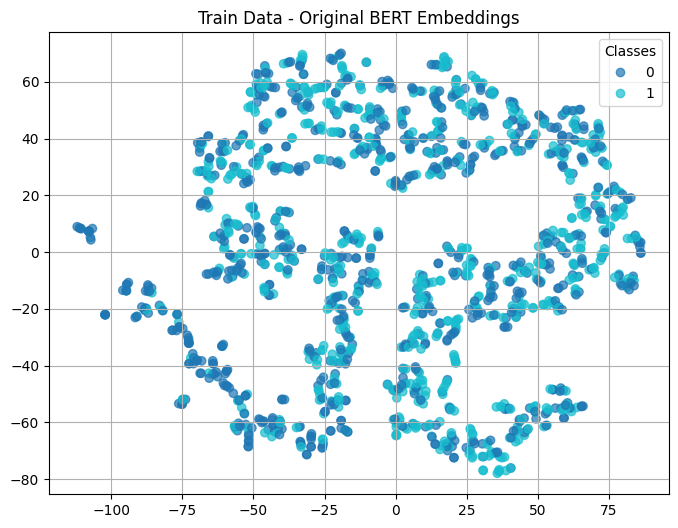

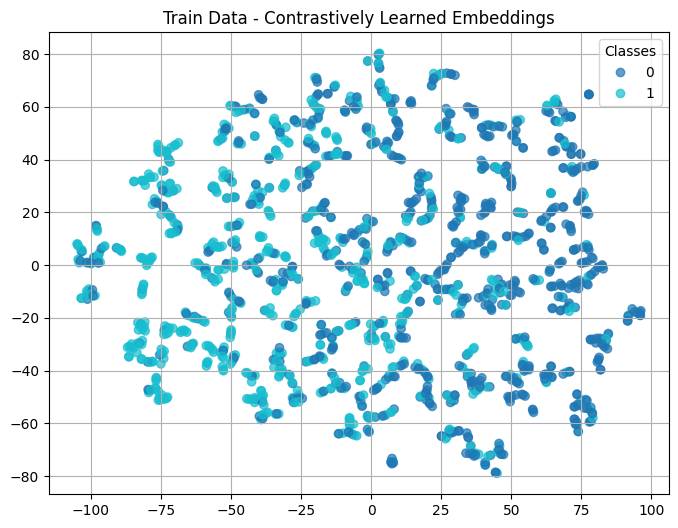

In [26]:
vanilla_embeddings, vanilla_labels = get_embeddings(vanilla_classifier, train_loader)
plot_embeddings(vanilla_embeddings, vanilla_labels, title="Train Data - Original BERT Embeddings").show()
print()
contrastive_embeddings, contrastive_labels = get_embeddings(classification_model, train_loader)
plot_embeddings(contrastive_embeddings, contrastive_labels, title="Train Data - Contrastively Learned Embeddings").show()

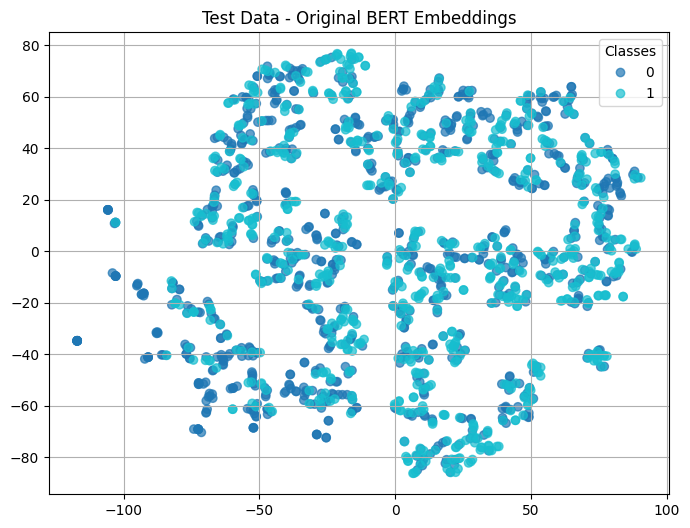

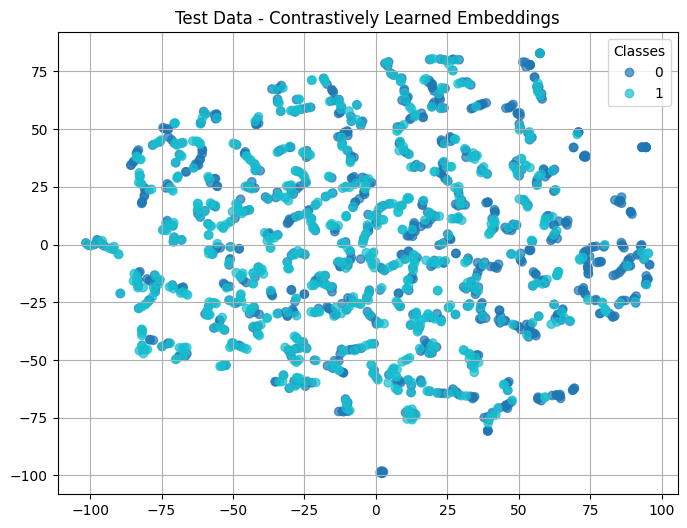

In [27]:
vanilla_embeddings, vanilla_labels = get_embeddings(vanilla_classifier, test_loader)
plot_embeddings(vanilla_embeddings, vanilla_labels, title="Test Data - Original BERT Embeddings").show()
print()
contrastive_embeddings, contrastive_labels = get_embeddings(classification_model, test_loader) # classification_model
plot_embeddings(contrastive_embeddings, contrastive_labels, title="Test Data - Contrastively Learned Embeddings").show()

In [ ]:
import copy
# print("Fine-tuning for classification...")
# classification_model = ClassificationModel(model.encoder, num_classes=7).to(device)

# # Dummy classifier training
# criterion = nn.CrossEntropyLoss()
# optimizer = AdamW(classification_model.parameters(), lr=2e-5)
# bert = BertModel.from_pretrained('bert-base-cased')
# bert.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/wac_project/QA_v2/models/contrastive_bert_binary_normal_encoder.pt"))



# num_classes = df['label'].nunique()
# classification_model = ClassificationModel(bert.encoder, num_classes=num_classes).to(device)

wait  = 0
best_val_loss = float("inf")
patience = 3
patience_counter = 0
best_model_state = None  # Optional: to restore the best model

for epoch in range(20):  # can be more than 5 since early stopping will take care
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / (1754 // 32 + 1)
    print(f"Validation Loss: {avg_val_loss:.2f}")

    # Early Stopping Logic
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      patience_counter = 0
      best_model_state = copy.deepcopy(model.state_dict())
    else:
      patience_counter += 1
      if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# Restore best model weights (optional but recommended)
if best_model_state is not None:
    model.load_state_dict(best_model_state)

Epoch 1, Train Loss: 5.8783
Validation Loss: 5.31
Epoch 2, Train Loss: 5.1234
Validation Loss: 4.92
Epoch 3, Train Loss: 4.8674
Validation Loss: 4.79
Epoch 4, Train Loss: 4.7722
Validation Loss: 4.74
Epoch 5, Train Loss: 4.7315
Validation Loss: 4.71
Epoch 6, Train Loss: 4.7104
Validation Loss: 4.70
Epoch 7, Train Loss: 4.6978
Validation Loss: 4.69
Epoch 8, Train Loss: 4.6896
Validation Loss: 4.68
Epoch 9, Train Loss: 4.6839
Validation Loss: 4.68
Epoch 10, Train Loss: 4.6798
Validation Loss: 4.68
Epoch 11, Train Loss: 4.6767
Validation Loss: 4.67
Epoch 12, Train Loss: 4.6743
Validation Loss: 4.67
Epoch 13, Train Loss: 4.6724
Validation Loss: 4.67


In [ ]:
test_dataset = ClassificationDataset(test_texts, test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32)

# Evaluate
model.eval()
from sklearn.metrics import classification_report

all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

In [ ]:
print("embedding mean/std", contrastive_embeddings.mean().item(), contrastive_embeddings.std().item())

In [ ]:
vanilla_model = ContrastiveBERT().to(device)  # untrained
model_b = ClassificationModel(vanilla_model.encoder, num_classes=num_classes).to(device)

wait  = 0
best_val_loss = float("inf")
patience = 3
patience_counter = 0
best_model_state = None  # Optional: to restore the best model

for epoch in range(20):  # can be more than 5 since early stopping will take care
    model_b.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model_b(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")

    # Validation
    model_b.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model_b(input_ids, attention_mask)
            loss = criterion(logits, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / (1754 // 32 + 1)
    print(f"Validation Loss: {avg_val_loss:.2f}")

    # Early Stopping Logic
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      patience_counter = 0
      best_model_state = copy.deepcopy(model_b.state_dict())
    else:
      patience_counter += 1
      if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# Restore best model weights (optional but recommended)
if best_model_state is not None:
    model_b.load_state_dict(best_model_state)

model_b.eval()
from sklearn.metrics import classification_report

all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model_b(input_ids, attention_mask)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

In [ ]:
for batch in val_loader:
  labels = batch['label'].to(device)
  print(len(labels))
  break

In [ ]:
# def test_ensemble_model(models, test_inputs, test_labels, batch_size=32):
#   def hard_voting(tensors):
#       np_tensors = [t.numpy() for t in tensors]
#       stacked = np.stack(np_tensors)

#       result = []
#       for i in range(stacked.shape[1]):
#           col = stacked[:, i]
#           count = Counter(col)

#           max_freq = max(count.values())
#           most_common_values = [val for val, freq in count.items() if freq == max_freq]
#           result.append(min(most_common_values))

#       return torch.tensor(result)

#   y_true = test_labels.cpu().numpy()

#   print(f'Total No. Models - {len(models)}')
#   model_predictions = []
#   for model in models:
#     model.eval()
#     all_preds = []

#     with torch.no_grad():
#         for i in range(0, len(test_labels), batch_size):
#             batch_inputs = {k: v[i:i+batch_size] for k, v in test_inputs.items()}
#             label_batch = test_labels[i:i+batch_size]

#             logits = model(**batch_inputs)#.logits
#             preds = torch.argmax(logits, dim=1)

#             all_preds.extend(preds.cpu().numpy())

#     model_predictions.append(torch.tensor(all_preds))
#     torch.cuda.empty_cache()
#     torch.cuda.ipc_collect()

#   final_predictions = hard_voting(model_predictions).numpy()

#   performance_metrics = np.asarray(precision_recall_fscore_support(y_true, final_predictions, labels=num_labels, zero_division=0))

#   return performance_metrics.T

In [ ]:
from google.colab import runtime
runtime.unassign()